# Linear Inverted Pendulum with Wall, Hybrid MPC Demo

This is a demo for the Model Predictive Control (MPC) package $\texttt{mpc_tools}$.

In [1]:
#%load_ext autoreload
#%autoreload 2
#%pylab notebook

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pympc.dynamical_systems as ds
import pympc.plot as mpc_plt
from pympc.control import MPCHybridController, HybridPolicyLibrary
from pympc.geometry import Polytope

We stabilize a linear inverted pendulum with mass $m$ and length $l$, subject to the gravity acceleration $g$. The pendulum is allowed to impact with an elastic wall (with stiffness $k$) placed at distance $d$ from the vertical line passing trough the hinge.

In [3]:
m = 1.
l = 1.
g = 10.
k = 1000.
d = .1
t_s = .01

We express the linearized dynamics in PieceWise Affine (PWA) form:
\begin{equation}
\dot x =
\begin{cases}
A_1 x + B_1 u + c_1, \quad \text{if} \quad (x, u) \in \mathcal D_1, \\
A_2 x + B_2 u + c_2, \quad \text{if} \quad (x, u) \in \mathcal D_2,
\end{cases}
\end{equation}

with

\begin{equation}
A_1 = 
\begin{bmatrix}
0 & 1 \\ g/l & 0
\end{bmatrix},
\quad
B_1 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_1 = 
\begin{bmatrix}
0 \\ 0
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_1 =
\{ (x,u) \ | \ x_1 \leq d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}

\begin{equation}
A_2 = 
\begin{bmatrix}
0 & 1 \\ g/l - k/m & 0
\end{bmatrix},
\quad
B_2 = 
\begin{bmatrix}
0 \\ 1/(ml^2)
\end{bmatrix},
\quad
c_2 = 
\begin{bmatrix}
0 \\ kd/(ml)
\end{bmatrix},
\end{equation}

\begin{equation}
\mathcal D_2 =
\{ (x,u) \ | \ x_1 > d/l, \ x_{min} \leq x \leq x_{max}, \ u_{min} \leq u \leq u_{max} \},
\end{equation}


The discrete-time PWA system can be defined from its continuous-time representation setting a sampling time $t_s$.

In [4]:
# discretization method
method = 'explicit_euler'

# dynamics n.1
A_1 = np.array([[0., 1.],[g/l, 0.]])
B_1 = np.array([[0.],[1/(m*l**2.)]])
c_1 = np.array([[0.],[0.]])
S_1 = ds.DTAffineSystem.from_continuous(A_1, B_1, c_1, t_s, method)

# dynamics n.2
A_2 = np.array([[0., 1.],[g/l-k/m, 0.]])
B_2 = B_1
c_2 = np.array([[0.],[k*d/(m*l)]])
S_2 = ds.DTAffineSystem.from_continuous(A_2, B_2, c_2, t_s, method)

# list of dynamics
S = [S_1, S_2]

The domains of the PWA have to be expressed as polytopes.

In [5]:
# state domain n.1
x_max_1 = np.array([[d/l], [1.]])
x_min_1 = -np.array([[d/l*1.2],[x_max_1[1,0]]])
X_1 = Polytope.from_bounds(x_min_1, x_max_1)
X_1.assemble()

# state domain n.2
x_min_2 = np.array([[x_max_1[0,0]], [x_min_1[1,0]]])
x_max_2 = -x_min_1
X_2 = Polytope.from_bounds(x_min_2, x_max_2)
X_2.assemble()

# list of state domains
X = [X_1, X_2]

# input domain
u_max = np.array([[4.]])
u_min = -u_max
U = Polytope.from_bounds(u_min, u_max)
U.assemble()
U = [U]*2

We can now define the PWA system.

In [6]:
pwa_sys = ds.DTPWASystem.from_orthogonal_domains(S, X, U)

At each each step, the following optimal control is solved
\begin{align}
\min \quad &
\sum_{k=0}^{N-1} (x_k^T Q x_k + u_k^T R u_k) + x_N^T P x_N \\
\text{subject to} \quad &
x_{k+1} =
\begin{cases}
A_1 x_k + B_1 u_k + c_1, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_1, \\
A_2 x_k + B_2 u_k + c_2, \quad \text{if} \quad (x_k, u_k) \in \mathcal D_2,
\end{cases}, \\
& (x_k, u_k) \in \mathcal D_1 \cup \mathcal D_2, \quad k = 1,2,\ldots,N-1, \\
& x_N \in \mathcal X_N, \\
& x_0 \ \text{given}, \\
\end{align}
and the input $u_0$ is applied to the system.

In [7]:
# controller parameters
N = 10
Q = np.eye(A_1.shape[0])
R = np.eye(B_1.shape[1])
objective_norm = 'two'

# terminal set and cost
P, K = ds.dare(S[0].A, S[0].B, Q, R)
X_N = ds.moas_closed_loop(S[0].A, S[0].B, K, X[0], U[0])

# hybrid controller
controller = MPCHybridController(pwa_sys, N, objective_norm, Q, R, P, X_N)

We can now simulate the closed-loop dynamics startion from the initial state $x_0$.

In [8]:
N_sim = 100
x_0 = np.array([[.05],[.52]])
u = []
x = []
miqp_times = []
x.append(x_0)
for k in range(N_sim):
    tic = time.clock()
    u.append(controller.feedback(x[k]))
    miqp_times.append(time.clock() - tic)
    x_next = pwa_sys.simulate(x[k], [u[k]])[0][1]
    x.append(x_next)

We can use the plot functions to visualize the time evolution of the system.

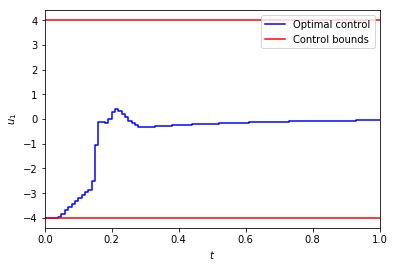

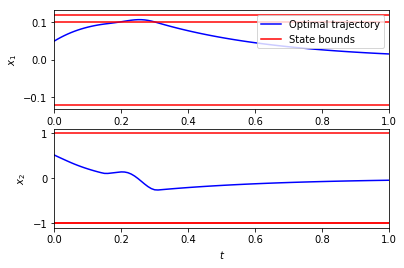

In [9]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_1, x_min_2, x_max_2))
plt.show()

In [10]:
# initialization of the library

policy = HybridPolicyLibrary(controller)

# coverage

n_samples = 10**3
terminal_domain = 0
policy.sample_policy(n_samples, terminal_domain, X, U)

Backwards reachability analysis for the switching sequence (0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
Feasible set computed in 0.743254899979 s
rejected sample 1
rejected sample 2
rejected sample 3
rejected sample 4
rejected sample 5
unfeasible sample 6
rejected sample 7
rejected sample 8
rejected sample 9
rejected sample 10
rejected sample 11
unfeasible sample 12
unfeasible sample 13
rejected sample 14
Backwards reachability analysis for the switching sequence (1, 1, 0, 0, 0, 0, 0, 0, 0, 0)
Feasible set computed in 0.635645866394 s
Backwards reachability analysis for the switching sequence (1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
Feasible set computed in 0.94717001915 s
rejected sample 16
rejected sample 17
rejected sample 18
rejected sample 19
rejected sample 20
rejected sample 21
rejected sample 22
unfeasible sample 23
rejected sample 24
rejected sample 25
rejected sample 26
rejected sample 27
rejected sample 28
unfeasible sample 29
rejected sample 30
rejected sample 31
unfeasible sample 32
unfeasible sa

In [11]:
# bound optimal value functions

n_samples = 10**5
policy.add_vertices_of_feasible_regions()
policy.bound_optimal_value_functions(n_samples)

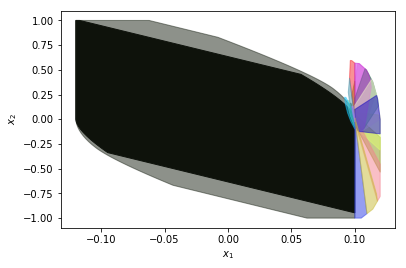

In [12]:
# plot feasible regions

X_N.plot(color='k')
for ss_value in policy.library.values():
    color = np.random.rand(3,1)
    ss_value['feasible_set'].plot(color=color, alpha=.5)
plt.show()

In [13]:
import time
# simulate closed loop

u = []
x = []
policy_times = []
x.append(x_0)
for k in range(N_sim):
    tic = time.clock()
    u.append(policy.feedback(x[k]))
    policy_times.append(time.clock() - tic)
    x.append(pwa_sys.simulate(x[k], [u[k]])[0][1])

In [14]:
print 'policy times (min, max, mean):', min(policy_times), max(policy_times), np.mean(policy_times)
print 'miqp times (min, max, mean):', min(miqp_times), max(miqp_times), np.mean(miqp_times)

policy times (min, max, mean): 0.00349 0.01738 0.00655707
miqp times (min, max, mean): 0.017843 0.136737 0.0345304


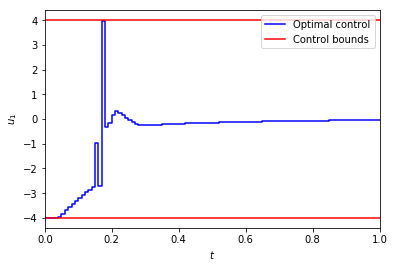

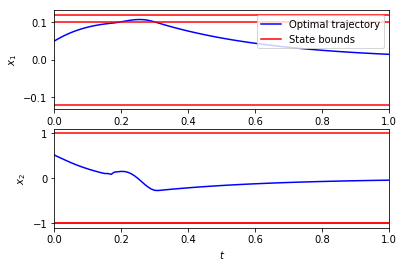

In [15]:
mpc_plt.input_sequence(u, t_s, (u_min, u_max))
plt.show()
mpc_plt.state_trajectory(x, t_s, (x_min_1, x_min_2, x_max_2))
plt.show()